In [1]:
# 필요한 패키지 설치
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
#from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [6]:
df = pd.read_csv('data/walmart_cleaned.csv')
df.head

<bound method NDFrame.head of         Unnamed: 0  Store        Date  IsHoliday  Dept  Weekly_Sales  \
0                0      1  2010-02-05          0   1.0      24924.50   
1                1      1  2010-02-05          0  26.0      11737.12   
2                2      1  2010-02-05          0  17.0      13223.76   
3                3      1  2010-02-05          0  45.0         37.44   
4                4      1  2010-02-05          0  28.0       1085.29   
...            ...    ...         ...        ...   ...           ...   
421565      423281     45  2012-10-26          0  13.0      26240.14   
421566      423282     45  2012-10-26          0  16.0       2660.02   
421567      423283     45  2012-10-26          0  32.0       4131.54   
421568      423284     45  2012-10-26          0  83.0        717.82   
421569      423285     45  2012-10-26          0  98.0       1076.80   

        Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0             42.31       

In [7]:
df.head()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [8]:
df.columns

Index(['Unnamed: 0', 'Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [9]:
# Date2 컬럼 데이트타임 형식으로 변환, 정렬, 년도 추출
df['Date2'] = pd.to_datetime(df['Date'])
df = df.sort_values(by = 'Date2')
df['year'] = df['Date2'].dt.year

In [10]:
# 집계 함수
def func(df):
    df_sum = {}
    df_sum['Weekly_Sales'] = df['Weekly_Sales'].sum()
    df_sum['Temperature'] = df['Temperature'].mean()
    df_sum['Fuel_Price'] = df['Fuel_Price'].mean()
    df_sum['IsHoliday'] = df['IsHoliday'].max()
    df_sum['CPI'] = df['CPI'].mean()
    df_sum['Unemployment'] = df['Unemployment'].mean()
    return pd.Series(df_sum, index = ['Weekly_Sales','Temperature','Fuel_Price','IsHoliday','CPI','Unemployment'])

df_agg = df.groupby(['year','Date2']).apply(func).reset_index()

In [11]:
df_agg

,year,Date2,Weekly_Sales,Temperature,Fuel_Price,IsHoliday,CPI,Unemployment
0,2010,2010-02-05,49750740.50,33.277942,2.717869,0.0,167.398405,8.576731
1,2010,2010-02-12,48336677.63,33.361810,2.696102,1.0,167.384138,8.567309
2,2010,2010-02-19,48276993.78,37.038310,2.673666,0.0,167.338966,8.576351
3,2010,2010-02-26,43968571.13,38.629563,2.685642,0.0,167.691019,8.561375
4,2010,2010-03-05,46871470.30,42.373998,2.731816,0.0,167.727351,8.572689
...,...,...,...,...,...,...,...,...
138,2012,2012-09-28,43734899.40,68.151759,3.858245,0.0,175.919639,7.225855
139,2012,2012-10-05,47566639.31,65.456811,3.848435,0.0,175.998254,6.942141
140,2012,2012-10-12,46128514.25,57.687284,3.897425,0.0,176.123786,6.952682
141,2012,2012-10-19,45122410.57,60.152756,3.878413,0.0,176.295499,6.948928


Text(0.5, 1.0, 'Weekly Sales')

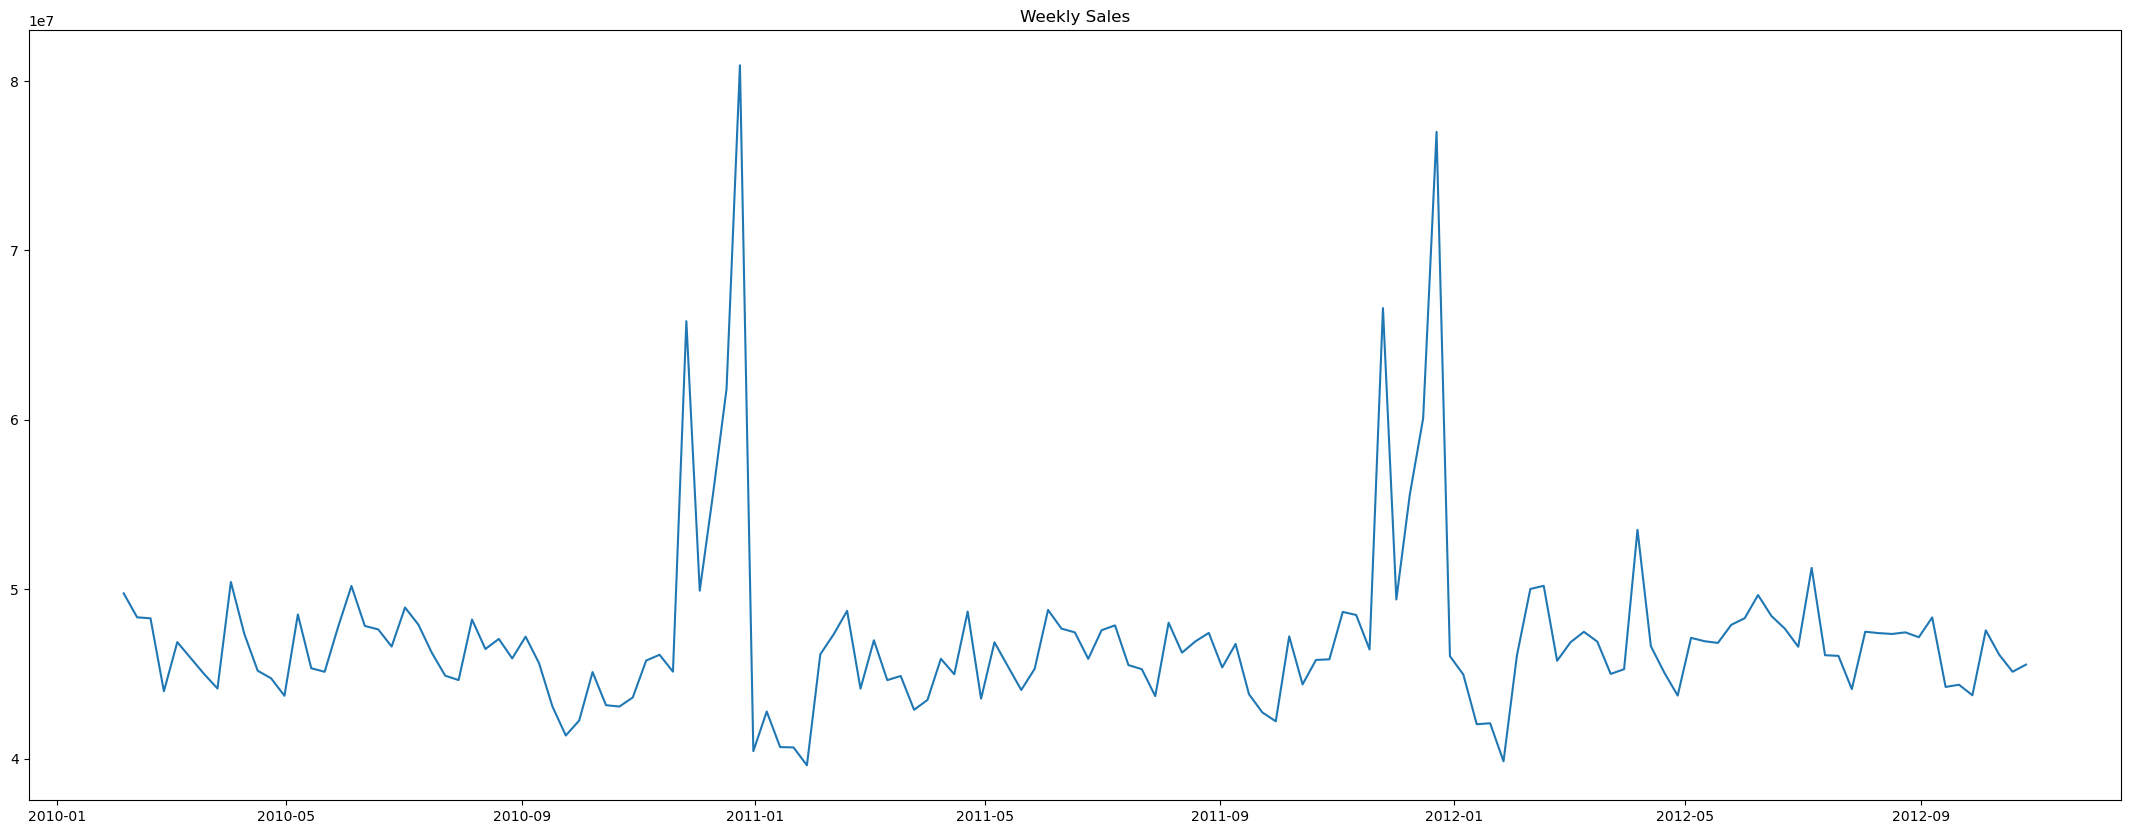

In [12]:
# 추세/변동 확인
plt.figure(figsize = (27,10))
plt.plot(df_agg.Date2, df_agg.Weekly_Sales)
plt.title('Weekly Sales')

In [14]:
# decomp 분해
timeseries_decomp = df_agg.loc[:,['Date2','Weekly_Sales']]
timeseries_decomp.index = timeseries_decomp.Date2
timeseries_decomp

,Date2,Weekly_Sales
Date2,,
2010-02-05,2010-02-05,49750740.50
2010-02-12,2010-02-12,48336677.63
2010-02-19,2010-02-19,48276993.78
2010-02-26,2010-02-26,43968571.13
2010-03-05,2010-03-05,46871470.30
...,...,...
2012-09-28,2012-09-28,43734899.40
2012-10-05,2012-10-05,47566639.31
2012-10-12,2012-10-12,46128514.25


In [15]:
ts_decomp = timeseries_decomp.drop('Date2',axis = 1)

In [16]:
ts_decomp

,Weekly_Sales
Date2,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


In [18]:
# 시계열 분해 : seasonal_decompose(패턴 확인, 월 :12, 주별 :4, 일별:7 지정)

decomp = seasonal_decompose(ts_decomp['Weekly_Sales'], model = 'additive', period = 4)

<Figure size 640x480 with 0 Axes>

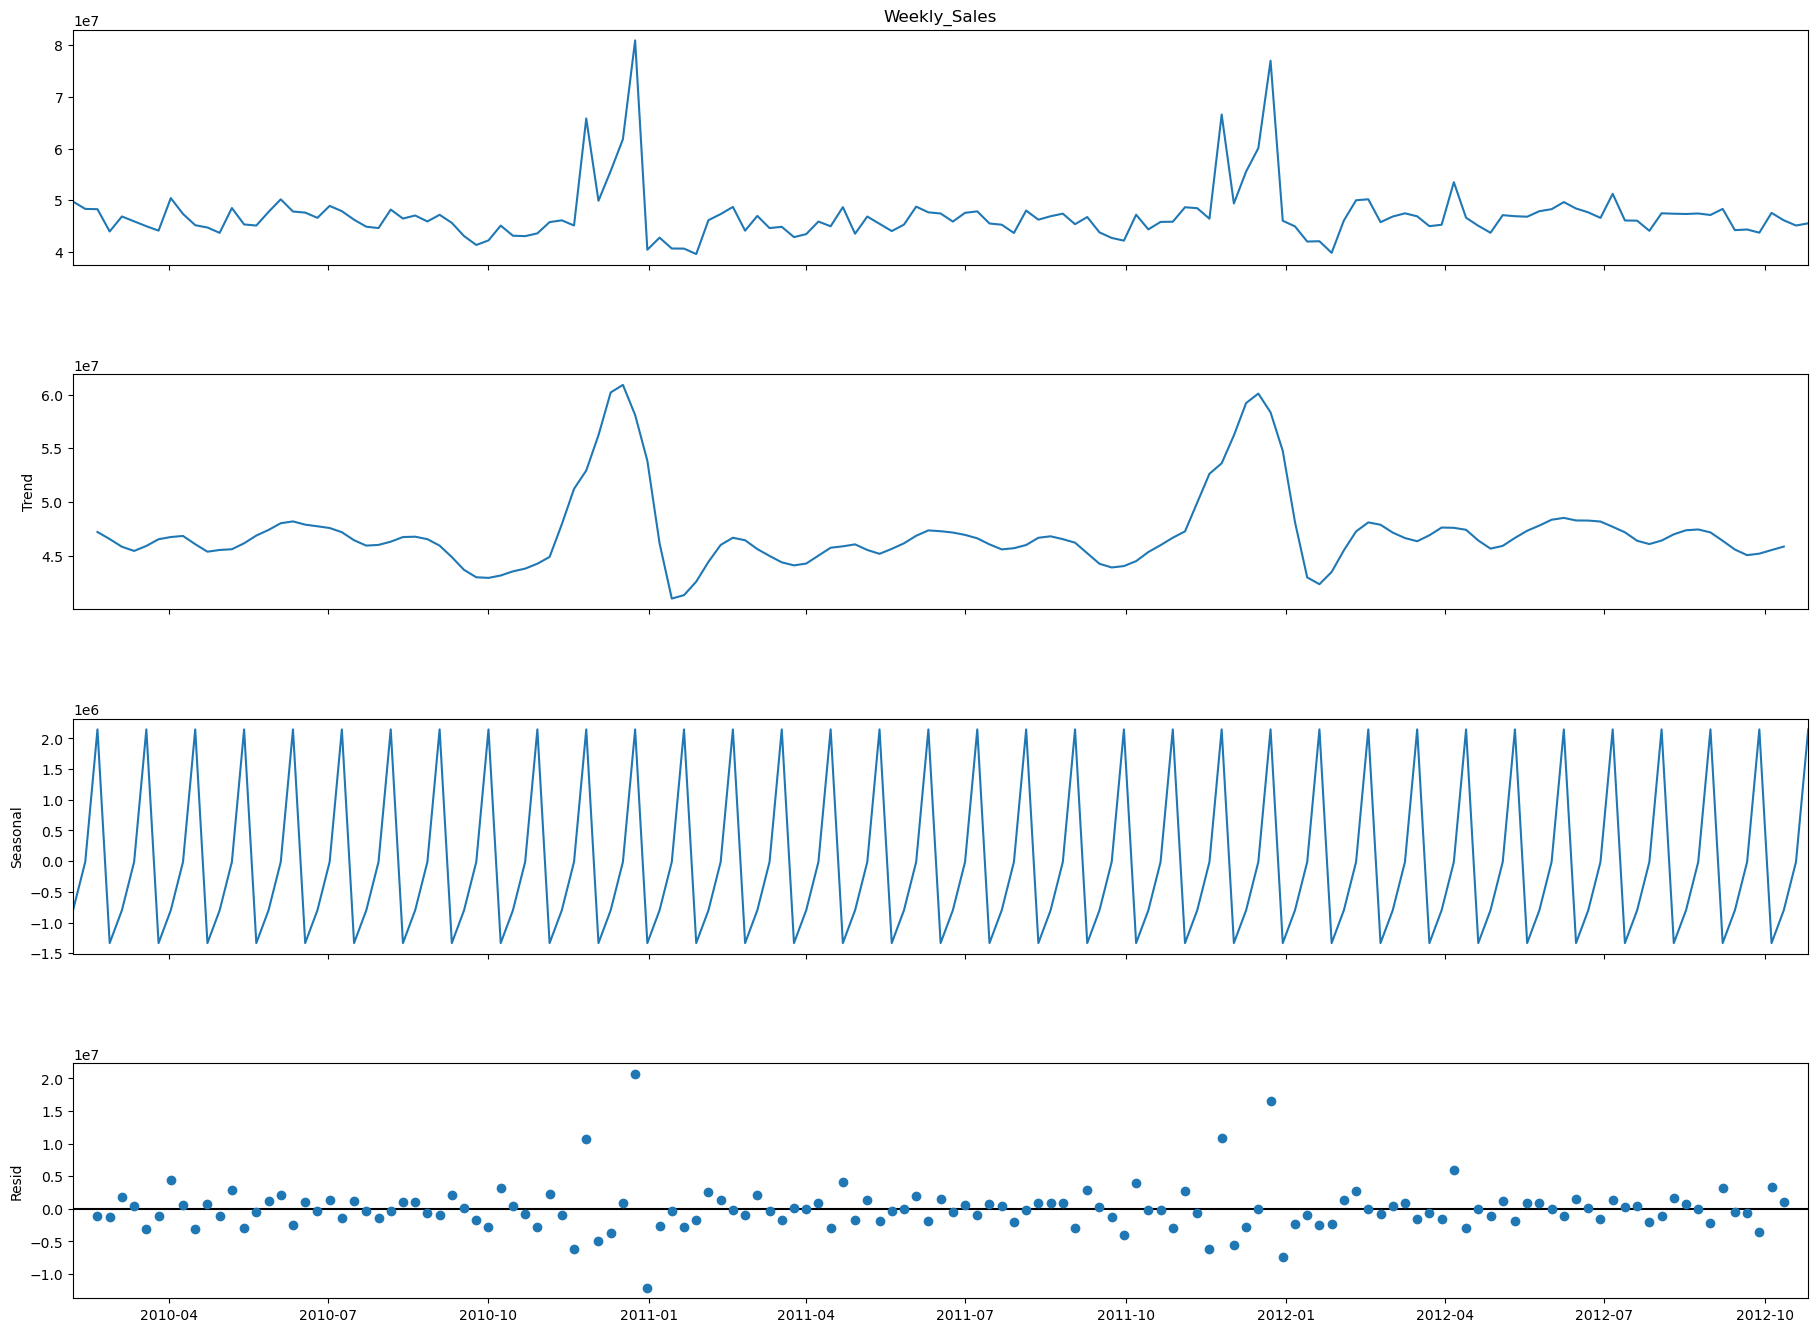

In [21]:
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(20,15)
plt.show()

### ACF, PACF 함수 그래프 그리기

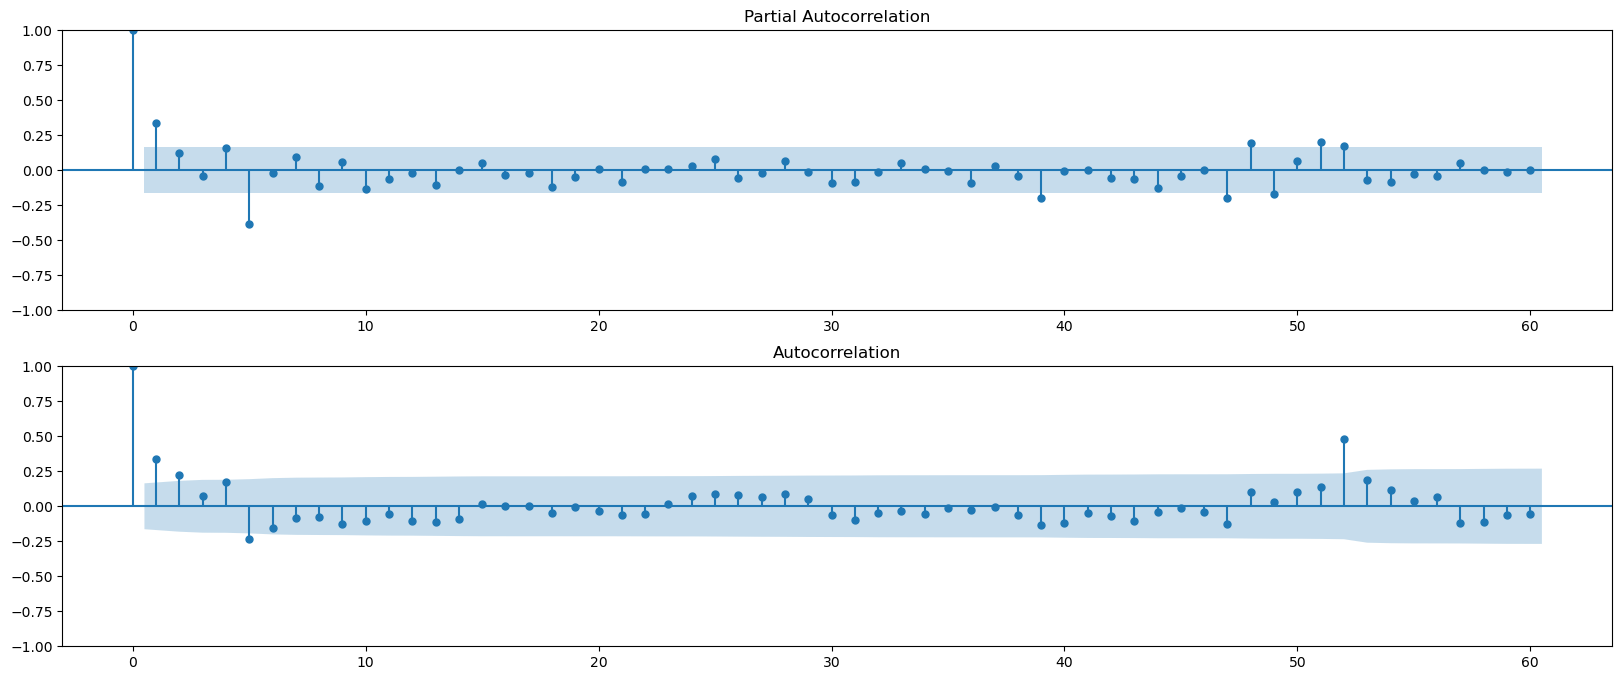

In [22]:
fig =plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(ts_decomp, lags=60, ax=ax1)

ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(ts_decomp, lags=60, ax=ax2)

- 1주전의 영향이 있는 것으로 보인다.
- 연말에 그래프에 나온 것처럼 영향력이 있다는 것을 확인!

### 1. 회귀분석을 통한 예측
- 다항회귀 개념의 예측 > 변수 여러개 사용 가능

In [25]:
df_agg['Weekly_Sales_1w']= df_agg['Weekly_Sales'].shift(1)
df_agg['Weekly_Sales_2w']=df_agg['Weekly_Sales'].shift(2)
df_agg['Weekly_Sales_3w']=df_agg['Weekly_Sales'].shift(3)
df_agg['Weekly_Sales_4w']=df_agg['Weekly_Sales'].shift(4)
df_agg['Weekly_Sales_52w']=df_agg['Weekly_Sales'].shift(52)


#모델의 학습을 하기 위해서 데이터 기간을 설정!

df_agg[df_agg['Date2'].isin(pd.date_range('2011-02-05', '2012-10-26'))]

# x와 y 독립변수와 종속변수 분리

df_x = df_agg.drop(['year','Date2','Weekly_Sales'],axis=1)
df_y = df_agg[['Weekly_Sales']]

# 테스트 데이터 트레인데이터 분리
df_x =df_x.fillna(0) # na값들을 0으로 인식하여 문제 발생!
x_train, x_test, y_train, y_test = train_test_split(
df_x, df_y, test_size=0.6, random_state=1)
# 시계열이지만 -> 쉐어를 진행했다. 회귀분석으로 진행을 하다보니!
# year, date 날렸다. 그냥 회귀분석의 개념으로 시계열 값은 날리고 예측을 진행

In [26]:
#다중 회귀 모델 학습
mreg = LinearRegression(fit_intercept=True)
mreg.fit(x_train, y_train)

# 테스트셋 모델 적용

y_predict = mreg.predict(x_test)

#모델 성능 확인

print('학습 데이터 R-Squarue {:.5f}'.format(mreg.score(x_train, y_train)))
print('테스트 데이터 R-Squarue {:.5f}'.format(mreg.score(x_test, y_test)))

학습 데이터 R-Squarue 0.37937
테스트 데이터 R-Squarue -0.03778


na값을 0으로 인식해서 결과가 이상하게 나옴

In [27]:
# 모델 상세 확인
ols_m = sm.OLS(y_train, sm.add_constant(x_train)).fit()
ols_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     2.812
Date:                Sun, 21 Jan 2024   Prob (F-statistic):            0.00833
Time:                        19:44:17   Log-Likelihood:                -912.83
No. Observations:                  57   AIC:                             1848.
Df Residuals:                      46   BIC:                             1870.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.548e+08   1.73e+08      0.895      0.376   -1.94e+08    5.03e+08
Temperature       3.064e+04   2.17e+04      1.412      0.165    -1.3e+04    7.43e+04
Fuel_Price        -6.13e+06   2.19e+06     -2.800      0.007   -1.05e+07   -1.72e+06
IsHoliday        -2.683e+05   1.63e+06     -0.165      0.870   -3.54e+06       3e+06
CPI              -3.749e+05   8.26e+05     -0.454      0.652   -2.04e+06    1.29e+06
Unemployment     -3.243e+06   4.39e+06     -0.739      0.464   -1.21e+07    5.59e+06
Weekly_Sales_1w      0.0258      0.057      0.452      0.653      -0.089       0.141
Weekly_Sales_2w      0.0593      0.058      1.020      0.313      -0.058       0.176
Weekly_Sales_3w     -0.1448      0.048     -3.004      0.004      -0.242      -0.048
Weekly_Sales_4w     -0.0072      0.041     -0.174      0.862      -0.091       0.076
Weekly_Sales_52w     0.1133      0.041      2.747      0.009       0.030       0.196
==============================================================================
Omnibus:                        1.549   Durbin-Watson:                   2.497
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                1.362
Skew:                           0.372   Prob(JB):                        0.506
Kurtosis:                       2.860   Cond. No.                     5.25e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 2. ARIMA

#### 2-1.ADF 검정을 통해서 p-value 값 확인
- 시계열 정상성 여부 판단, 귀무가설을 기각하지 못하면 차분,지연,로그 등으로 정상시계열로 만들어야함

In [28]:
def ADF(ts_decomp):
    result = adfuller(ts_decomp.values, autolag='AIC')
    print('TEST 진행')
    print('ADF Statistics 값 %f' % result[0])
    print('p-value 값 %f' %result[1])
    print('Lag 값 %f' %result[2])
    print('관측 값 %f' %result[3])
    print('기각역')
    for key, values in result[4].items():
        print('t%s: %.3f' % (key,values))

In [29]:
ADF(ts_decomp)

TEST 진행
ADF Statistics 값 -5.908298
p-value 값 0.000000
Lag 값 4.000000
관측 값 138.000000
기각역
t1%: -3.479
t5%: -2.883
t10%: -2.578


In [30]:
# Arima를 위한 학습셋, 테스트셋 나누기!

train = ts_decomp.loc['2010-02-05':'2012-09-21']
test = ts_decomp.loc['2012-09-28':'2012-10-26']

In [31]:
# p,d,q 값을 파라미터 설정해야 한다!
p,d,q = 2,0,2

model_arima = ARIMA(train['Weekly_Sales'], order=(p,d,q))
model_arima_fit = model_arima.fit()

In [32]:
#결과값 예측하기

pred1 = model_arima_fit.forecast(steps=5)[0]
pred1 = pd.Series(pred1, index= test.index)

print(np.round_(pred1,2))

Date2
2012-09-28    46540957.97
2012-10-05    46540957.97
2012-10-12    46540957.97
2012-10-19    46540957.97
2012-10-26    46540957.97
dtype: float64


<Axes: xlabel='Date2', ylabel='Weekly_Sales'>

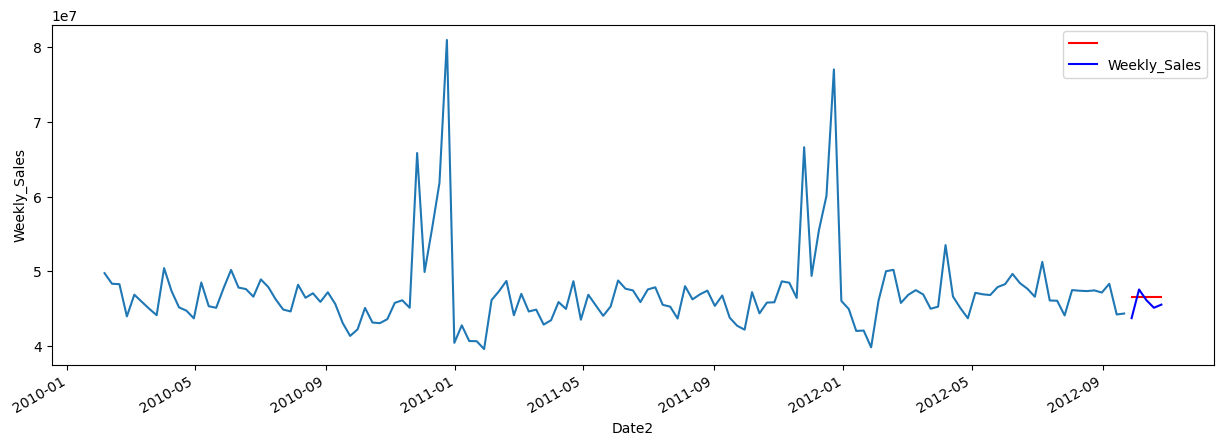

In [33]:
# 주기성, 계절성이 있는 데이터 > 학습을 놓칠 수 있다
fig, ax = plt.subplots(figsize=(15,5))
graph = sns.lineplot(x ='Date2', y='Weekly_Sales', data= train)
pred1.plot(ax=ax ,color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

<Axes: xlabel='Date2', ylabel='Weekly_Sales'>

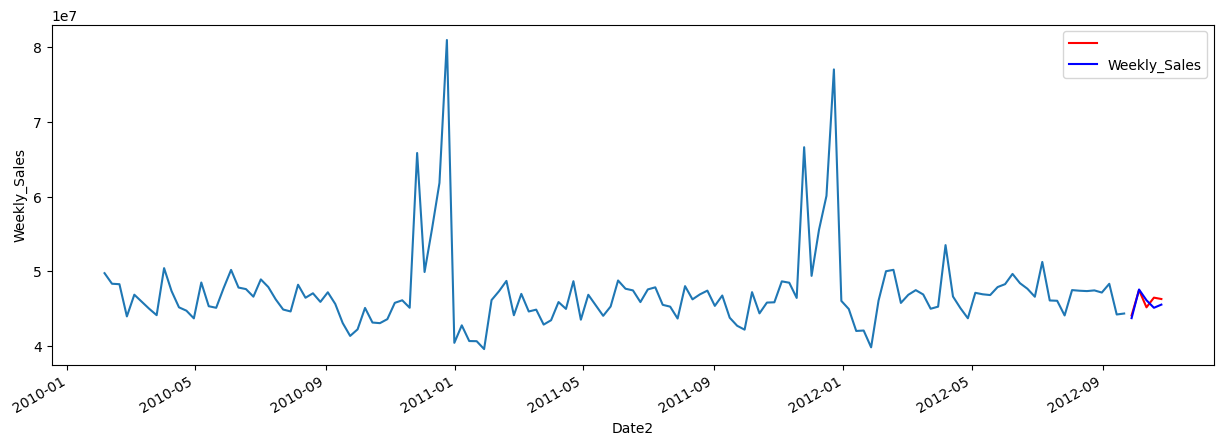

In [34]:
# Auto - Arima

auto_arima_model = pm.auto_arima(train, seasonal=True, m = 52)

pred2= auto_arima_model.predict(5)
pred2 = pd.Series(pred2, index= test.index)

#auto-ARIMA 학습 시각화
fig, ax = plt.subplots(figsize=(15,5))
graph = sns.lineplot(x ='Date2', y='Weekly_Sales', data= train)
pred2.plot(ax=ax ,color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

In [35]:
# auto_arima 모델요약
print(auto_arima_model.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  138
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -2296.614
Date:                             Sun, 21 Jan 2024   AIC                           4607.228
Time:                                     19:51:01   BIC                           4627.719
Sample:                                 02-05-2010   HQIC                          4615.555
                                      - 09-21-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.115e+07    1.7e-08   1.83e+15      0.000    3.12e+07    3.12e+07
ar.L1         -0.8130      

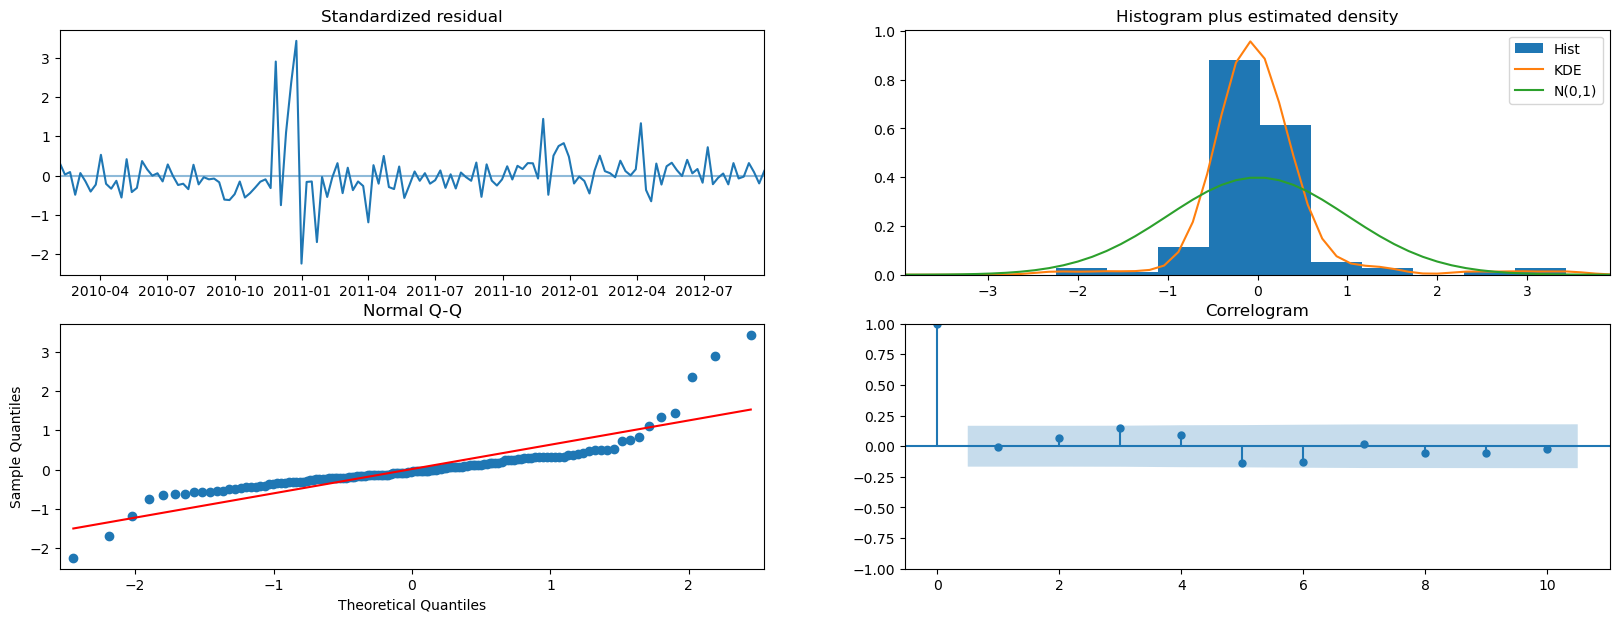

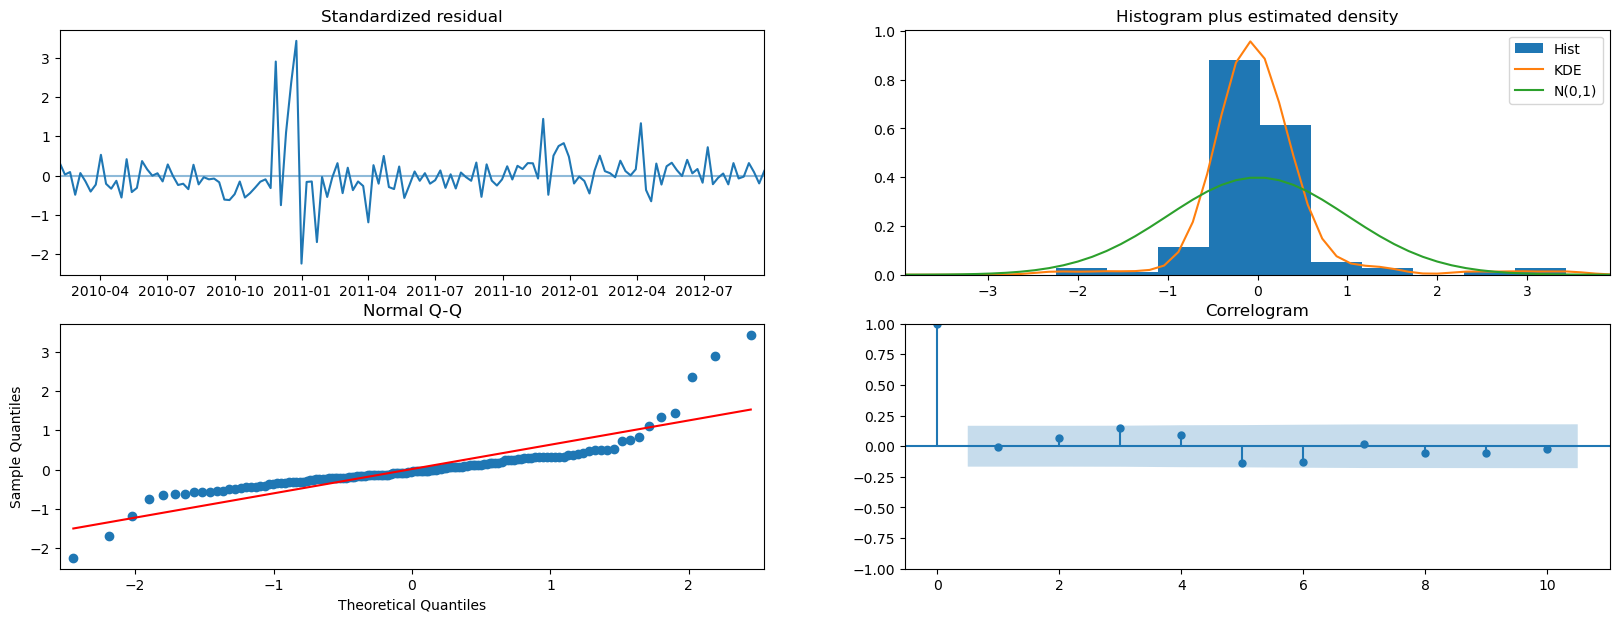

In [36]:
# 모델의 적합성 시각화
auto_arima_model.plot_diagnostics(figsize=(20,7))

### 3. Prophet 시계열 분석

In [38]:
df_prophet= df[['Date2','Weekly_Sales']]
df_prophet

,Date2,Weekly_Sales
0,2010-02-05,24924.50
330761,2010-02-05,5015.30
330762,2010-02-05,62831.98
330763,2010-02-05,10870.40
330764,2010-02-05,345.00
...,...,...
128051,2012-10-26,127416.33
128052,2012-10-26,2820.28
128053,2012-10-26,40228.51
390991,2012-10-26,26750.82


- prophet 은 ds, y로 컬럼을 변경해야 한다

In [39]:
def prepare_data(df, ds, y):
    df = df[[ds, y]]
    df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
    print('The series is ready for use.\n')
    return df

In [40]:
df5 = prepare_data(df_prophet, ds = 'Date2', y = 'Weekly_Sales') 
print(df5.head())
print('')
print('The length of your series is: ', df5.shape[0])

The series is ready for use.

               ds         y
0      2010-02-05  24924.50
330761 2010-02-05   5015.30
330762 2010-02-05  62831.98
330763 2010-02-05  10870.40
330764 2010-02-05    345.00

The length of your series is:  421570


In [41]:
df5['ds']=pd.to_datetime(df5['ds'])

df6=df5.set_index('ds')
df6=df6.resample('W').sum()
df6=df6.reset_index()


train = df6[:135]
test = df6[135:]

In [42]:
print(len(train))
print(len(test))
print(len(df6))

135
8
143


In [44]:
prophet = Prophet(daily_seasonality=False,
                  growth='linear', 
#                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8, 
                  yearly_seasonality='auto', 
                  weekly_seasonality='auto', 
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05)
#                  mcmc_samples=0, 
#                  interval_width=0.8, 
#                  uncertainty_samples=1000, 
#                  stan_backend=None)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=10)
forecast = prophet.predict(future)

19:55:09 - cmdstanpy - INFO - Chain [1] start processing
19:55:09 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-07,4.722267e+07,4.332343e+07,5.275728e+07,4.722267e+07,4.722267e+07,7.153494e+05,7.153494e+05,7.153494e+05,7.153494e+05,7.153494e+05,7.153494e+05,0.0,0.0,0.0,4.793802e+07
1,2010-02-14,4.721811e+07,4.423258e+07,5.318039e+07,4.721811e+07,4.721811e+07,1.427103e+06,1.427103e+06,1.427103e+06,1.427103e+06,1.427103e+06,1.427103e+06,0.0,0.0,0.0,4.864521e+07
2,2010-02-21,4.721355e+07,4.255331e+07,5.164528e+07,4.721355e+07,4.721355e+07,5.312778e+04,5.312778e+04,5.312778e+04,5.312778e+04,5.312778e+04,5.312778e+04,0.0,0.0,0.0,4.726668e+07
3,2010-02-28,4.720899e+07,4.095294e+07,5.057259e+07,4.720899e+07,4.720899e+07,-1.165673e+06,-1.165673e+06,-1.165673e+06,-1.165673e+06,-1.165673e+06,-1.165673e+06,0.0,0.0,0.0,4.604331e+07
4,2010-03-07,4.720442e+07,4.122344e+07,5.006063e+07,4.720442e+07,4.720442e+07,-1.447694e+06,-1.447694e+06,-1.447694e+06,-1.447694e+06,-1.447694e+06,-1.447694e+06,0.0,0.0,0.0,4.575673e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2012-09-08,4.792620e+07,4.114516e+07,5.138116e+07,4.792620e+07,4.792620e+07,-1.479503e+06,-1.479503e+06,-1.479503e+06,-1.479503e+06,-1.479503e+06,-1.479503e+06,0.0,0.0,0.0,4.644669e+07
141,2012-09-09,4.792769e+07,4.152463e+07,5.075769e+07,4.792769e+07,4.792769e+07,-1.782584e+06,-1.782584e+06,-1.782584e+06,-1.782584e+06,-1.782584e+06,-1.782584e+06,0.0,0.0,0.0,4.614511e+07
142,2012-09-10,4.792919e+07,4.163902e+07,5.058079e+07,4.792916e+07,4.792919e+07,-2.096912e+06,-2.096912e+06,-2.096912e+06,-2.096912e+06,-2.096912e+06,-2.096912e+06,0.0,0.0,0.0,4.583227e+07
143,2012-09-11,4.793068e+07,4.105477e+07,4.987122e+07,4.793063e+07,4.793071e+07,-2.417360e+06,-2.417360e+06,-2.417360e+06,-2.417360e+06,-2.417360e+06,-2.417360e+06,0.0,0.0,0.0,4.551332e+07


Printing outputs from Prophet prediction...
           ds          yhat    yhat_lower    yhat_upper
0 2010-02-07  4.793802e+07  4.332343e+07  5.275728e+07
1 2010-02-14  4.864521e+07  4.423258e+07  5.318039e+07
2 2010-02-21  4.726668e+07  4.255331e+07  5.164528e+07
3 2010-02-28  4.604331e+07  4.095294e+07  5.057259e+07
4 2010-03-07  4.575673e+07  4.122344e+07  5.006063e+07


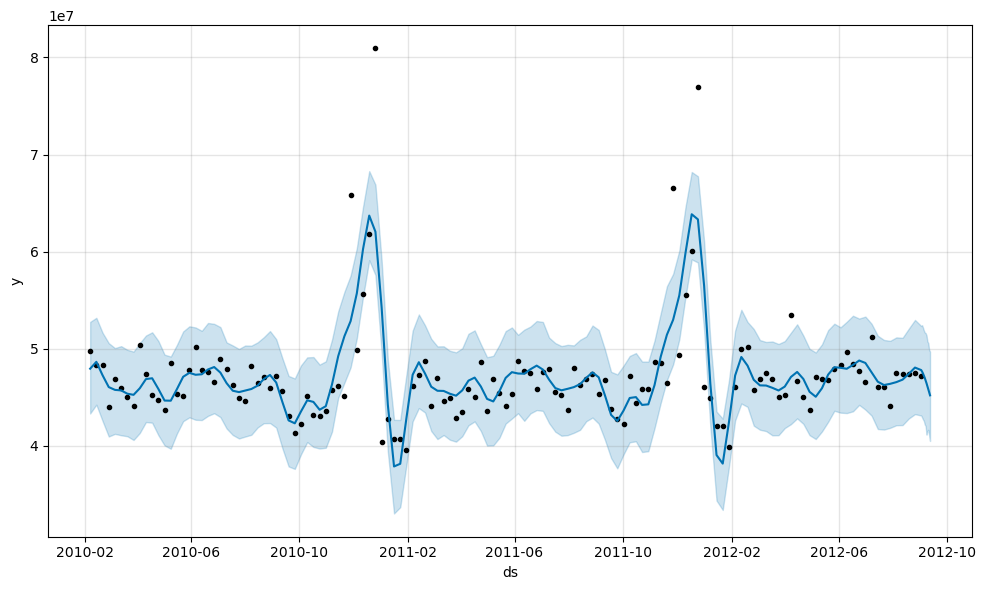

In [46]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [47]:
#y_true .rt\
print('Length of forcast series, train series, and original series: ', len(forecast), len(train), len(df6))
print(' ')
y_true= test['y'].values
y_pred = forecast['yhat'][-len(y_true):].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Length of forcast series, train series, and original series:  145 135 143
 
Mean Absolute Error: 1426381.203


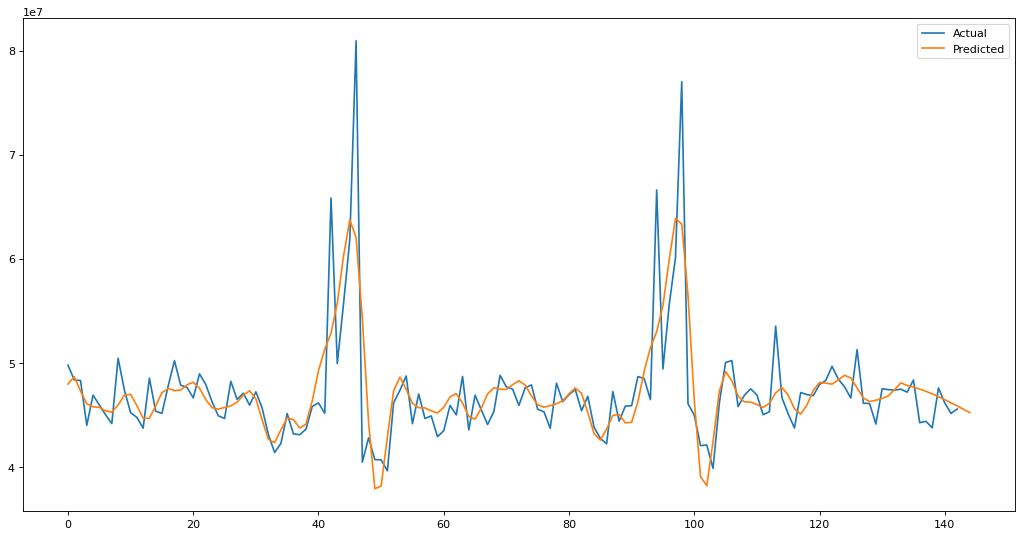

In [48]:
# plot expected vs actual
import matplotlib.pyplot as pltt
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)

pltt.plot(df6['y'].values, label='Actual')
pltt.plot(forecast['yhat'].values, label='Predicted')
pltt.legend()
pltt.show()

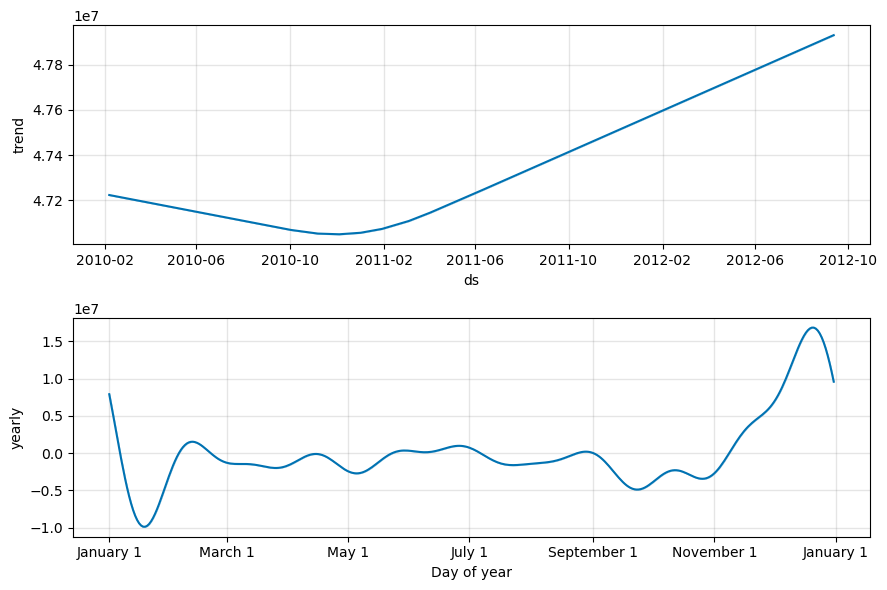

In [49]:
fig2 = prophet.plot_components(forecast)
plt.show()